In [1]:
# Only need this cell if you are using jupyter lab. Change path as needed
%cd /data/wesley/Milestone_Error_Analysis_Testing
!ls

/data/wesley/Milestone_Error_Analysis_Testing
Milestone_Polynomial_Model_Test.ipynb  analysis_functions.py
README.md			       asymmetric_case.raw_trajectory_data.csv
Untitled.ipynb			       symmetric_case.raw_trajectory_data.csv
__pycache__


In [2]:
import numpy as np
import pandas as pd
import matplotlib

from matplotlib import pyplot as plt
import seaborn as sns

import plotly as ply

import tqdm
import gc
import sys
import os

import scipy as sp

# Define Simple 1 Dimensional 1 Particle Brownian Dynamics Simulation

In [523]:
class Simple_1D_BD_Sim:
    def __init__(
        self, 
        potential_gradient_function,
        parameter_dict=None, 
        starting_coordinates=0, #technically 'coordinate' since this is 1D #1D function,takes a coordinate (x) and yields grad(U(x)). I.e. dU/dx
    ):
        self.kb=0.001985875 #kcal/(mol*K)
        self.parameter_dict=dict(
            diffusionConstant=1.0, #in Å**2/(fs) -> i.e. square distance per time unit
            temperature=310.15, # Kelvins (default = normal body temperature),
            vmax=1.5, #maximum allowed velocity (violation will terminate simulation due to instability)
            trajectorySnapshotRate=100, #number of steps between saving to trajectory data
            periodicBoundaryLength=None,
            timestep=1.0, #time step in fs
            verbose=False,
        )
        if not (parameter_dict is None):
            self.set_parameters(parameter_dict)
        if not (starting_coordinates is None):
            self.x0=starting_coordinates
        else:
            self.x0=0
            
        self.set_potential_gradient_function(potential_gradient_function)
        
        
    def set_parameters(self,parameter_dict):
        for parameterName in parameter_dict:
            if parameterName in self.parameter_dict: #make sure we dont add unsupported parameters
                self.parameter_dict[parameterName]=parameter_dict[parameterName]
            elif self.parameter_dict['verbose']:
                print('Warning: parameter "%s" not supported'%(str(parameterName)))
    
    def set_potential_gradient_function(self,potential_gradient_function):
        self.potential_gradient_function=potential_gradient_function
   
    def set_x0(self,x0):
        self.x0=x0
        
    def run_sim(
        self,
        nsteps=10000,
        giveVelocities=False,
        randomSeed=None,
        pbar=None,
    ):
        
        x=self.x0
        bPBL=self.parameter_dict['periodicBoundaryLength']
        if not (bPBL is None):
            x=x%bPBL
        bD=self.parameter_dict['diffusionConstant']
        kb=self.kb
        bT=self.parameter_dict['temperature']
        trajInterval=self.parameter_dict['trajectorySnapshotRate']
        verbose=self.parameter_dict['verbose']
        bVmax=self.parameter_dict['vmax']
        ts=self.parameter_dict['timestep']
        gradUfun=self.potential_gradient_function
        print(nsteps)
        if not (randomSeed is None): #in case we want to specify a specific random seed for reproducibility
            np.random.seed(randomSeed)
        trajectoryData=np.zeros(int(nsteps/trajInterval))
        if giveVelocities:
            velocityData=np.zeros(nsteps)
        
        tStep=0    
        stable=True
        # X'(t)=-D/(kbT)*grad(U(X))+√(2D)*R(t)
        #R -> stationary gaussian process
        while (tStep<nsteps) and stable:
            v=( -bD/(kb*bT)*gradUfun(x)+np.sqrt(2*bD)*np.random.normal(scale=1/np.sqrt(ts)) )*ts
            if (tStep%trajInterval) == 0:
                trajectoryData[int(tStep/trajInterval)]=x
                if giveVelocities:
                    velocityData[int(tStep/trajInterval)]=v
            if np.abs(v)>bVmax:
                stable=False
                if verbose:
                    print(
                        ("ERROR (step %g): velocity (%.3e) exceeds maximum (%.3e),"+\
                        "simulation terminated due to instability")%(
                            tStep,v,bVmax
                        )
                    )
            if not pbar is None:
                pbar.update()
            x=x+v
            if not (bPBL is None):
                x=x%bPBL
            tStep=tStep+1
        outDict=dict(
            trajectory=trajectoryData[:(int(tStep/trajInterval)+1)]
        )
        if giveVelocities:
            outDict['velocities']=velocityData[:(int(tStep/trajInterval)+1)]
        return(outDict)

'kbT/2=3.080E-01'

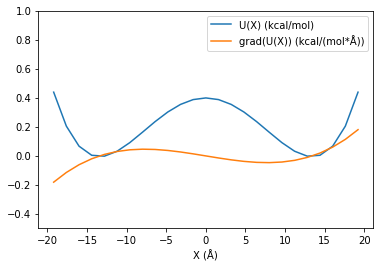

/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


2000000
<v**2>/2=0.03158115 at D=0.031 fs; <|v|>=0.20067191 at timestep=1.000; total steps = 2e+06 (2.0000 ns)



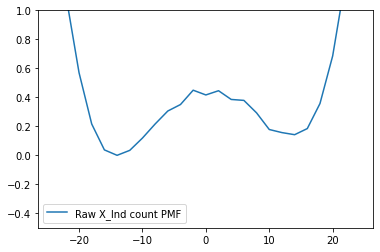

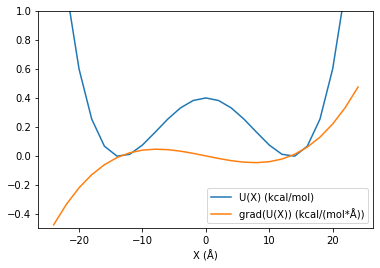

/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


2000000
<v**2>/2=0.06386406 at D=0.062 fs; <|v|>=0.28542346 at timestep=1.000; total steps = 2e+06 (2.0000 ns)



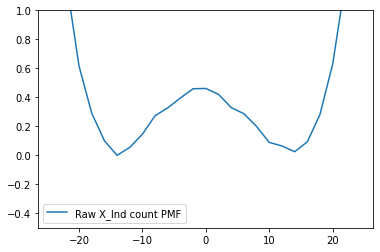

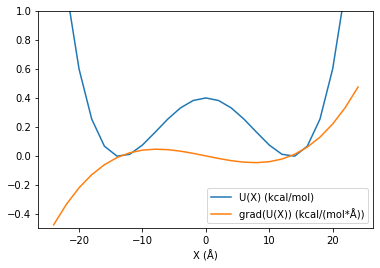

/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


2000000
<v**2>/2=0.12412549 at D=0.125 fs; <|v|>=0.39775111 at timestep=1.000; total steps = 2e+06 (2.0000 ns)



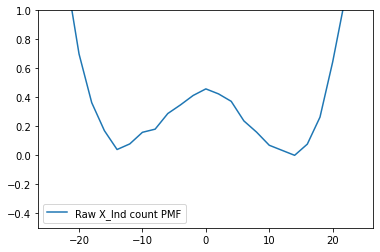

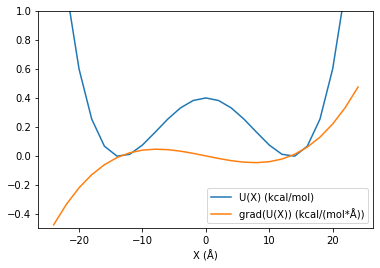

/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


2000000
<v**2>/2=0.24979992 at D=0.250 fs; <|v|>=0.56468843 at timestep=1.000; total steps = 2e+06 (2.0000 ns)



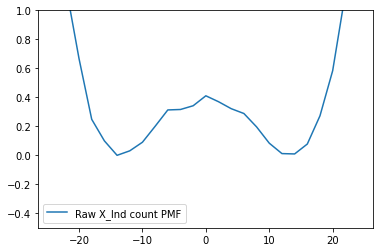

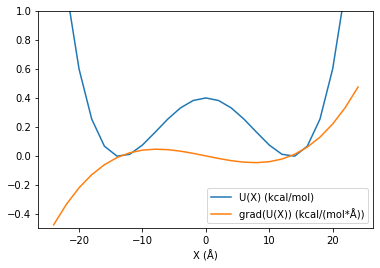

In [527]:
display(
    'kbT/2=%.3E'%(
        bd_TestSim.parameter_dict['temperature']*kb/2.
    )
)

def potFunTest(x):
    return (1./80000.)*x**4+(.4-(.45/100)*x**2)
def potGradFunTest(x):
    return 4*(1./80000)*x**3-2*(.45/100)*x

binEdges=np.linspace(-20,20,26)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
xgrid=binCenters#np.linspace(-30,30,101)
sns.lineplot(
    x=xgrid,
    y=potFunTest(xgrid),
    label='U(X) (kcal/mol)'
)
sns.lineplot(
    x=xgrid,
    y=potGradFunTest(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)
plt.ylim(-.5,1.)
plt.xlabel('X (Å)')
plt.show()

binEdges=np.linspace(-25,25,26)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
for sim_dt in [1.]:
    for sim_D in [.03125,.0625,.125,.25]:#,.0625,.125,.25,.5,1.]:
        diffCoef=sim_D
        bd_TestSim=Simple_1D_BD_Sim(potGradFunTest)
        bd_TestSim.set_parameters(dict(
            diffusionConstant=diffCoef,
            vmax=15.0,
            trajectorySnapshotRate=int(100/sim_dt),
            verbose=True,
            timestep=sim_dt
        ))
        bd_TestSim.set_x0(0.)
        nsteps=int(2000000/sim_dt) #100000000
        trajTestData=bd_TestSim.run_sim(
            nsteps=nsteps,
            giveVelocities=True,
            pbar=tqdm.tqdm_notebook(total=nsteps))

        kb=bd_TestSim.kb
        dt=bd_TestSim.parameter_dict['timestep']
        print(
            '<v**2>/2={hvsq:.8f} at D={D:.3f} fs'.format(
                D=bd_TestSim.parameter_dict['diffusionConstant'],
                hvsq=np.mean((trajTestData['velocities']/dt)**2/2.))+ \
            '; <|v|>={v:.8f} at timestep={ts:.3f}'.format(
                ts=bd_TestSim.parameter_dict['timestep'],
                v=np.mean(np.abs(trajTestData['velocities'])/dt))+ \
            '; total steps = {nts:g} ({simtime:.4f} ns)'.format(
                nts=nsteps, simtime=nsteps*bd_TestSim.parameter_dict['timestep']*1E-6
            )
        )
        xgrid=binCenters
        test_pmf_hist=np.histogram(
            a=trajTestData['trajectory'],
            bins=binEdges
        )
        test_pmf_vec=test_pmf_hist[0]
        test_pmf_vec=test_pmf_vec/np.sum(test_pmf_vec)
        test_pmf_vec=-kbT*np.log(test_pmf_vec/np.max(test_pmf_vec))
        sns.lineplot(
            x=xgrid,
            y=test_pmf_vec,
            label='Raw X_Ind count PMF'
        )
        plt.ylim(-.5,1.)
        plt.show()

        xgrid=binCenters#np.linspace(-30,30,101)
        sns.lineplot(
            x=xgrid,
            y=potFunTest(xgrid),
            label='U(X) (kcal/mol)'
        )
        sns.lineplot(
            x=xgrid,
            y=potGradFunTest(xgrid),
            label='grad(U(X)) (kcal/(mol*Å))'
        )
        plt.ylim(-.5,1.)
        plt.xlabel('X (Å)')
        plt.show()

'kbT/2=3.080E-01'

/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


4000000
<v**2>/2=0.03100767 at D=0.031 fs; <|v|>=0.19880703 at timestep=0.125


/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


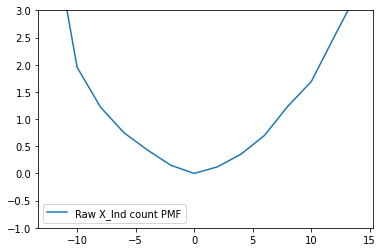

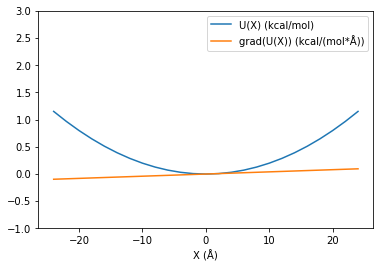

In [497]:
display(
    'kbT/2=%.3E'%(
        bd_TestSim.parameter_dict['temperature']*kb/2.
    )
)
binEdges=np.linspace(-25,25,26)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
sim_dt=.125
for sim_D in [.03125]: #,.0625,.125,.25,.5,1.]:
    def potFunTest(x):
        return (.2/100.)*x**2
    def potGradFunTest(x):
        return 2*(.2/100)*x
    diffCoef=sim_D
    bd_TestSim=Simple_1D_BD_Sim(potGradFunTest)
    bd_TestSim.set_parameters(dict(
        diffusionConstant=diffCoef,
        vmax=15.0,
        trajectorySnapshotRate=100,
        verbose=True,
        timestep=sim_dt
    ))
    bd_TestSim.set_x0(0.)
    nsteps=4000000 #100000000
    trajTestData=bd_TestSim.run_sim(
        nsteps=nsteps,
        giveVelocities=True,
        pbar=tqdm.tqdm_notebook(total=nsteps))

    kb=bd_TestSim.kb
    dt=bd_TestSim.parameter_dict['timestep']
    print(
        '<v**2>/2={hvsq:.8f} at D={D:.3f} fs'.format(
            D=bd_TestSim.parameter_dict['diffusionConstant'],
            hvsq=np.mean((trajTestData['velocities']/dt)**2/2.))+ \
        '; <|v|>={v:.8f} at timestep={ts:.3f}'.format(
            ts=bd_TestSim.parameter_dict['timestep'],
            v=np.mean(np.abs(trajTestData['velocities'])/dt))
    )
    xgrid=binCenters
    test_pmf_hist=np.histogram(
        a=trajTestData['trajectory'],
        bins=binEdges
    )
    test_pmf_vec=test_pmf_hist[0]
    test_pmf_vec=test_pmf_vec/np.sum(test_pmf_vec)
    test_pmf_vec=-kbT*np.log(test_pmf_vec/np.max(test_pmf_vec))
    sns.lineplot(
        x=xgrid,
        y=test_pmf_vec,
        label='Raw X_Ind count PMF'
    )
    plt.ylim(-1,3)
    plt.show()

    xgrid=binCenters#np.linspace(-30,30,101)
    sns.lineplot(
        x=xgrid,
        y=potFunTest(xgrid),
        label='U(X) (kcal/mol)'
    )
    sns.lineplot(
        x=xgrid,
        y=potGradFunTest(xgrid),
        label='grad(U(X)) (kcal/(mol*Å))'
    )
    plt.ylim(-1,3)
    plt.xlabel('X (Å)')
    plt.show()

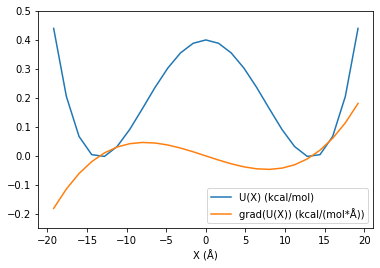

In [486]:
def potFunTest(x):
    return (1./80000.)*x**4+(.4-(.45/100)*x**2)
def potGradFunTest(x):
    return 4*(1./80000)*x**3-2*(.45/100)*x

binEdges=np.linspace(-20,20,26)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
xgrid=binCenters#np.linspace(-30,30,101)
sns.lineplot(
    x=xgrid,
    y=potFunTest(xgrid),
    label='U(X) (kcal/mol)'
)
sns.lineplot(
    x=xgrid,
    y=potGradFunTest(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)
plt.ylim(-.25,.5)
plt.xlabel('X (Å)')
plt.show()

<v**2>/2=0.03134800; D=0.031 fs; <|v|>=0.20004000; ts=0.500


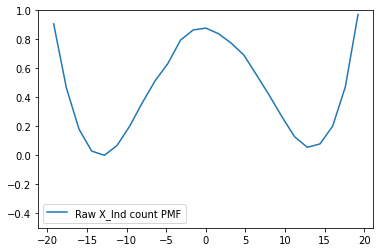

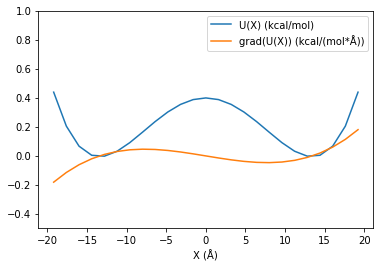

In [494]:
kb=bd_TestSim.kb
dt=bd_TestSim.parameter_dict['timestep']
print(
    '<v**2>/2={hvsq:.8f}; D={D:.3f} fs'.format(
        D=bd_TestSim.parameter_dict['diffusionConstant'],
        hvsq=np.mean((trajTestData['velocities']/dt)**2/2.))+ \
    '; <|v|>={v:.8f}; ts={ts:.3f}'.format(
        ts=bd_TestSim.parameter_dict['timestep'],
        v=np.mean(np.abs(trajTestData['velocities'])/dt))
)
xgrid=binCenters
test_pmf_hist=np.histogram(
    a=trajTestData['trajectory'],
    bins=binEdges
)
test_pmf_vec=test_pmf_hist[0]
test_pmf_vec=test_pmf_vec/np.sum(test_pmf_vec)
test_pmf_vec=-kbT*np.log(test_pmf_vec/np.max(test_pmf_vec))
sns.lineplot(
    x=xgrid,
    y=test_pmf_vec,
    label='Raw X_Ind count PMF'
)
plt.ylim(-.5,1.)
plt.show()

xgrid=binCenters#np.linspace(-30,30,101)
sns.lineplot(
    x=xgrid,
    y=potFunTest(xgrid),
    label='U(X) (kcal/mol)'
)
sns.lineplot(
    x=xgrid,
    y=potGradFunTest(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)
plt.ylim(-.5,1.)
plt.xlabel('X (Å)')
plt.show()

In [318]:
display(
    'kbT/2=%.3E'%(
        bd_TestSim.parameter_dict['temperature']*kb/2.
    )
)
for sim_dt in [.25,.5,1.,2.]:
    def potFunTest(x):
        return 0
    def potGradFunTest(x):
        return 0

    diffCoef=.0282*310.15/298.15 #Approximate scaling to body temperature 

    bd_TestSim=Simple_1D_BD_Sim(potGradFunTest)
    bd_TestSim.set_parameters(dict(
        diffusionConstant=diffCoef,
        vmax=15.0,
        trajectorySnapshotRate=1000,
        verbose=True,
        timestep=sim_dt
    ))
    bd_TestSim.set_x0(-25.)
    nsteps=1000000 #100000000
    trajTestData=bd_TestSim.run_sim(
        nsteps=nsteps,
        giveVelocities=True,
        pbar=tqdm.tqdm_notebook(total=nsteps))

    kb=bd_TestSim.kb
    dt=bd_TestSim.parameter_dict['timestep']
    print(
        '<v**2>/2={hvsq:.8f} at timestep={ts:.3f} fs'.format(
            ts=dt,
            hvsq=np.mean((trajTestData['velocities']/dt)**2/2.))+ \
        '; <|v|>={v:.8f} at timestep={ts:.3f}'.format(
            ts=dt,
            v=np.mean(np.abs(trajTestData['velocities'])/dt))
    )

'kbT/2=3.080E-01'

/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000
<v**2>/2=0.11690663 at timestep=0.250 fs; <|v|>=0.38275799 at timestep=0.250


1000000
<v**2>/2=0.05727792 at timestep=0.500 fs; <|v|>=0.27137474 at timestep=0.500


1000000
<v**2>/2=0.03246563 at timestep=1.000 fs; <|v|>=0.20008196 at timestep=1.000




1000000
<v**2>/2=0.01459672 at timestep=2.000 fs; <|v|>=0.13739141 at timestep=2.000


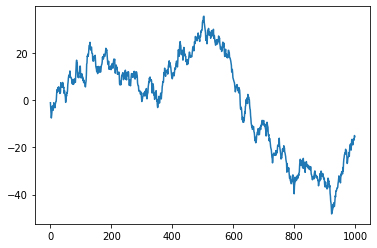

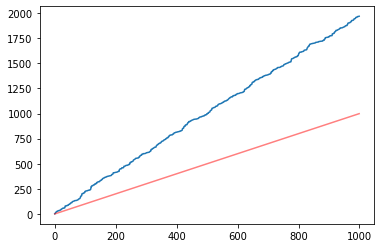

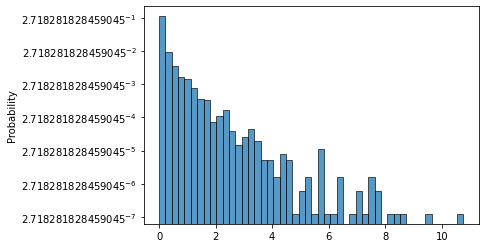

In [267]:
nsteps=1000
xvals=np.arange(nsteps)
vvals=np.sqrt(2)*np.random.normal(size=nsteps)
sns.lineplot(
    x=xvals,
    y=np.cumsum(vvals)
)
plt.show()
sns.lineplot(
    x=xvals,
    y=np.cumsum(vvals**2)
)
sns.lineplot(
    x=xvals,
    y=xvals,
    color='red',
    alpha=.5
)
plt.show()
fig,axs=plt.subplots(1,1)
sns.histplot(
    x=.5*vvals**2,
    stat='probability',
    ax=axs
)
axs.set_yscale('log',base=np.e)
plt.show()

In [205]:
import sklearn as skl
from sklearn import linear_model as lm

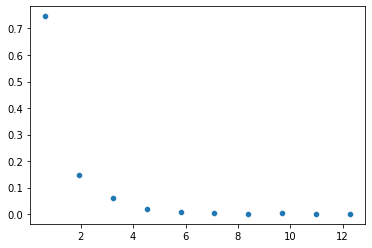

y=-5.602E-01*x + -8.928E-01


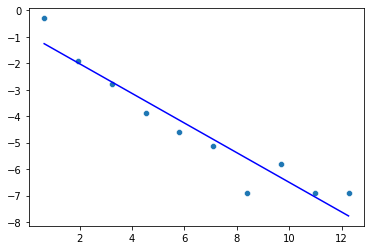

In [226]:
vhist=np.histogram(.5*vvals**2)
ke_probs=vhist[0]/np.sum(vhist[0])
ke_vals=(vhist[1][1:]+vhist[1][:-1])/2.
sns.scatterplot(
    x=ke_vals,
    y=ke_probs
)
plt.show()
sns.scatterplot(
    x=ke_vals,
    y=np.log(ke_probs)
)

LinReg=lm.LinearRegression()
linFit=LinReg.fit(np.atleast_2d(ke_vals).T,np.atleast_2d(-np.log(ke_probs)).T)
print('y={coef:.3E}*x + {intercept:.3E}'.format(
    coef=-linFit.coef_.flatten()[0],intercept=-linFit.intercept_[0]))
sns.lineplot(
    x=ke_vals,
    y=-linFit.coef_.flatten()[0] * ke_vals-linFit.intercept_[0],
    color='blue'
)
plt.show()

# Zero Potential Test Case

In [280]:
def potFunTest(x):
    return 0
def potGradFunTest(x):
    return 0

diffCoef=.0282*310.15/298.15 #Approximate scaling to body temperature 

bd_TestSim=Simple_1D_BD_Sim(potGradFunTest)
bd_TestSim.set_parameters(dict(
    diffusionConstant=diffCoef,
    vmax=15.0,
    trajectorySnapshotRate=1000,
    verbose=True,
    timestep=2
))
bd_TestSim.set_x0(-25.)
nsteps=1000000 #100000000
trajTestData=bd_TestSim.run_sim(
    nsteps=nsteps,
    giveVelocities=True,
    pbar=tqdm.tqdm_notebook(total=nsteps))

kb=bd_TestSim.kb
dt=bd_TestSim.parameter_dict['timestep']
display(
    '%.3E'%(
        bd_TestSim.parameter_dict['temperature']*kb/2.
    )
)
np.mean((trajTestData['velocities']/dt)**2/2.)

/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000


500 frames per ns



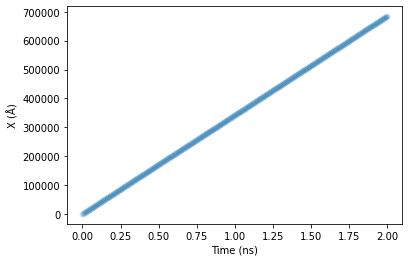

In [281]:
dt=bd_TestSim.parameter_dict['timestep']*1E-6*bd_TestSim.parameter_dict['trajectorySnapshotRate']
print('%g frames per ns'%(1./dt))
sns.scatterplot(
    x=np.arange(len(trajTestData['trajectory']))*dt,
    y=trajTestData['trajectory'],alpha=.125
)
plt.ylabel('X (Å)')
plt.xlabel('Time (ns)')
plt.show()

In [282]:
test_sim_data=pd.DataFrame(
{
    'Time':np.arange(len(trajTestData['trajectory'])),
    'X':trajTestData['trajectory'],
    'V':trajTestData['velocities'][1:]
}
)
test_sim_data.head()

,Time,X,V
0,0,-25.000000,1.329521
1,1,658.610502,0.438154
2,2,1341.426090,1.073317
3,3,2016.378515,0.496888
4,4,2682.344650,0.520578


In [283]:
kb=bd_TestSim.kb
dt=bd_TestSim.parameter_dict['timestep']
display(
    '%.3E'%(
        bd_TestSim.parameter_dict['temperature']*kb/2.
    )
)
np.mean((trajTestData['velocities']/dt)**2/2.)

'3.080E-01'

0.0836991648538192

In [236]:
np.mean(np.random.standard_normal(size=1000)**2)

0.9971557183691814

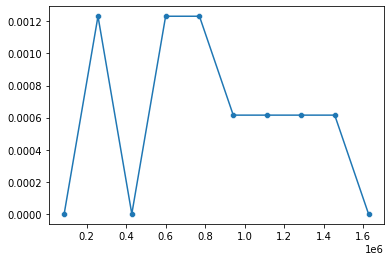

In [243]:
test_pi_hist=np.histogram(test_sim_data['X'])
test_pi_vec=test_pi_hist[0]
test_pi_vec=test_pi_vec/np.sum(test_pi_vec)
test_pi_centers=(test_pi_hist[1][1:]+test_pi_hist[1][:-1])/2.
kb=bd_TestSim.kb
Tsim=bd_TestSim.parameter_dict['temperature']
kbT=kb*Tsim
test_pmf_vec=-kbT*np.log(test_pi_vec/np.max(test_pi_vec))

sns.lineplot(
    x=test_pi_centers,
    y=test_pmf_vec
)
sns.scatterplot(
    x=test_pi_centers,
    y=test_pmf_vec
)
plt.show()

The above pmf is off... but that is expected since with no underlying potential brownian dynamics will wander off and may, in fact, never converge.

Lets see if we can check convergence using a large flat bottom well.

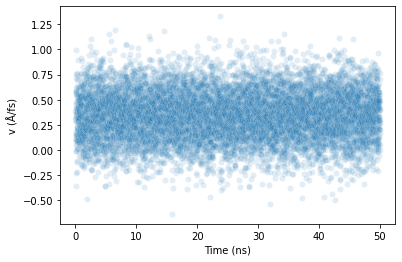

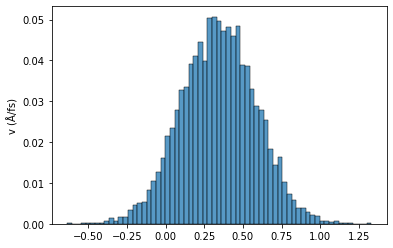

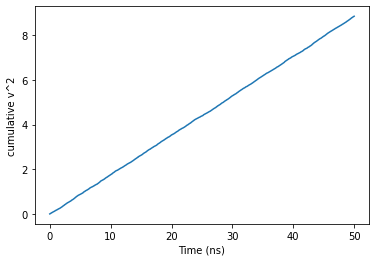

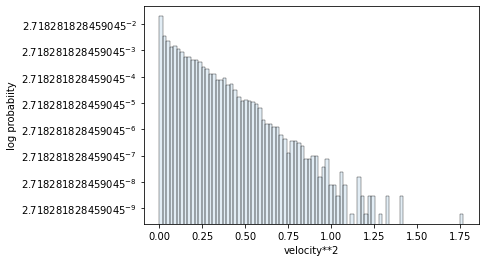

In [244]:
dt=bd_TestSim.parameter_dict['timestep']
sns.scatterplot(
    x=np.arange(len(trajTestData['velocities']))*.005,
    y=trajTestData['velocities']/dt,alpha=.125
)
plt.ylabel('v (Å/fs)')
plt.xlabel('Time (ns)')
plt.show()

sns.histplot(
    x=trajTestData['velocities']/dt,
    stat='probability'
)
plt.ylabel('v (Å/fs)')
plt.show()

sns.lineplot(
    x=np.arange(len(trajTestData['velocities']))*.005,
    y=np.cumsum((trajTestData['velocities']/dt)**2)*.005
)
plt.ylabel('cumulative v^2')
plt.xlabel('Time (ns)')
plt.show()

fig,axs=plt.subplots(1,1)
sns.histplot(
    x=(trajTestData['velocities']/dt)**2,alpha=.125,
    stat='probability',ax=axs
)
plt.xlabel('velocity**2')
plt.ylabel('log probabiity')
axs.set_yscale('log',base=np.exp(1))
plt.show()

# Flat Bottom Well Case.

In [ ]:
def genFlatBottom(x,fb_min,fb_max,k):
    potFun=lambda x: (x<fb_min)*.5*k*(x-fb_min)**2 + \
        (x>fb_max)*.5*k*(x-fb_max)**2

## Simple symetric case

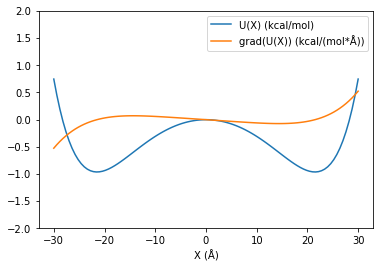

In [623]:
def potFun(x):
    return(5.0*(1.0/1024.0*(10**-6)*(x)**6-.0625*(10**-2)*(x)**2))
def potGradFun(x):
    return(5.0*(6.0*1.0/1024.0*(10**-6)*(x)**5-2.0*.0625*(10**-2)*(x)))

xgrid=np.linspace(-30,30,101)
sns.lineplot(
    x=xgrid,
    y=potFun(xgrid),
    label='U(X) (kcal/mol)'
)
sns.lineplot(
    x=xgrid,
    y=potGradFun(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)
plt.ylim(-2.0,2.0)
plt.xlabel('X (Å)')
plt.show()

In [626]:
#Air(g)-water(g) diffusion constant: .282 cm**2/s (at 25 ºC)
# -> (10**-8)**2/10**-15 = 10**-1 Å**2/fs per cm**2/s
# so Air-water = .0282 Å**2/fs
diffCoef=.0282*310.15/298.15 #Approximate scaling to body temperature 

bd_Sim=Simple_1D_BD_Sim(potGradFun)
bd_Sim.set_parameters(dict(
    diffusionConstant=diffCoef,
    vmax=15.0,
    trajectorySnapshotRate=1000,
    verbose=True,
    timestep=1.0
))
bd_Sim.set_x0(-20.)

In [627]:
display('x0=%f'%bd_Sim.x0)
bd_Sim.parameter_dict

'x0=-20.000000'

{'diffusionConstant': 0.02933499916149589,
 'temperature': 310.15,
 'vmax': 15.0,
 'trajectorySnapshotRate': 1000,
 'periodicBoundaryLength': None,
 'timestep': 1.0,
 'verbose': True}

/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


100000000


(array([5916, 6886, 6570, 5663, 4583, 3626, 2849, 2287, 2029, 1670, 1490,
        1346, 1382, 1340, 1447, 1622, 1841, 2166, 2698, 3346, 4287, 5217,
        6127, 6270, 5486]),
 array([-25., -23., -21., -19., -17., -15., -13., -11.,  -9.,  -7.,  -5.,
         -3.,  -1.,   1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,
         19.,  21.,  23.,  25.]))

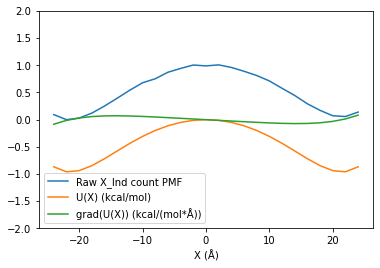

In [628]:
nsteps=100000000 #100000000
trajData=bd_Sim.run_sim(
    nsteps=nsteps,
    giveVelocities=True,
    pbar=tqdm.tqdm_notebook(total=nsteps))

binEdges=np.linspace(-25,25,26)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
xgrid=binCenters
sim_pmf_hist=np.histogram(
    a=trajData['trajectory'],
    bins=binEdges
)
display(sim_pmf_hist)
sim_pmf_vec=sim_pmf_hist[0]
sim_pmf_vec=sim_pmf_vec/np.sum(sim_pmf_vec)
sim_pmf_vec=-kbT*np.log(sim_pmf_vec/np.max(sim_pmf_vec))
sns.lineplot(
    x=xgrid,
    y=sim_pmf_vec,
    label='Raw X_Ind count PMF'
)
plt.ylim(-.5,1.5)
#plt.show()

xgrid=binCenters#np.linspace(-30,30,101)
sns.lineplot(
    x=xgrid,
    y=potFun(xgrid)-np.min(potFun(xgrid)),
    label='U(X) (kcal/mol)'
)
sns.lineplot(
    x=xgrid,
    y=potGradFun(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)
plt.ylim(-2,2)
plt.xlabel('X (Å)')
plt.show()

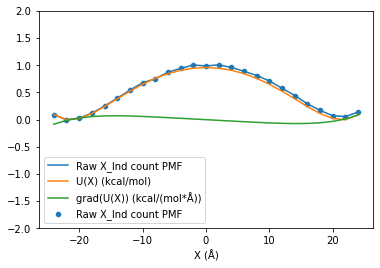

In [631]:
binEdges=np.linspace(-25,25,26)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
xgrid=binCenters
sim_pmf_hist=np.histogram(
    a=trajData['trajectory'],
    bins=binEdges
)
sim_pmf_vec=sim_pmf_hist[0]
sim_pmf_vec=sim_pmf_vec/np.sum(sim_pmf_vec)
sim_pmf_vec=-kbT*np.log(sim_pmf_vec/np.max(sim_pmf_vec))
sns.lineplot(
    x=xgrid,
    y=sim_pmf_vec,
    label='Raw X_Ind count PMF'
)
sns.scatterplot(
    x=xgrid,
    y=sim_pmf_vec,
    label='Raw X_Ind count PMF'
)
plt.ylim(-.2,.6)
#plt.show()

xgrid=binCenters#np.linspace(-30,30,101)
sns.lineplot(
    x=xgrid,
    y=potFun(xgrid)-np.min(potFun(xgrid)),
    label='U(X) (kcal/mol)'
)
sns.lineplot(
    x=xgrid,
    y=potGradFun(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)
plt.ylim(-2,2)
plt.xlabel('X (Å)')
plt.show()

In [632]:
trajTable=pd.DataFrame(dict(
    Time=np.arange(len(trajData['trajectory'])),
    X=trajData['trajectory']
))
if 'velocities' in trajData:
    trajTable['V']=trajData['velocities'][1:]
    
display(trajTable.head())
trajTable.to_csv('symmetric_case.raw_trajectory_data.csv')

with open('symmetric_case.raw_trajectory_simulation_parameters.json','w') as outfile:
    json.dump(bd_Sim.parameter_dict,outfile)
display(bd_Sim.parameter_dict)

,Time,X,V
0,0,-20.000000,-0.115835
1,1,-18.448328,0.058234
2,2,-21.740043,0.111448
3,3,-25.962215,-0.005899
4,4,-21.264881,-0.279032


{'diffusionConstant': 0.02933499916149589,
 'temperature': 310.15,
 'vmax': 15.0,
 'trajectorySnapshotRate': 1000,
 'periodicBoundaryLength': None,
 'timestep': 1.0,
 'verbose': True}

In [633]:
symmData=pd.read_csv("symmetric_case.raw_trajectory_data.csv")
symmData=symmData.drop(columns=symmData.columns[0])
symmData.head()

,Time,X,V
0,0,-20.000000,-0.115835
1,1,-18.448328,0.058234
2,2,-21.740043,0.111448
3,3,-25.962215,-0.005899
4,4,-21.264881,-0.279032


# Symmetric Case Milestoning Runs
Next, lets run milestoning

First we will build the needed window restraint potentials and gradients
then store them for each window

In [577]:
def gen_harmonic_window_potFun(potFun,win_center,kval):
    return(
        lambda x: potFun(x)+.5*kval*(x-win_center)**2
    )
def gen_harmonic_window_potGradFun(potGradFun,window_center,kval):
    return(
        lambda x: potGradFun(x)-kval*(window_center-x)
    )

def gen_flat_bottom_harmonic_window_potFun(potFun,win_lhs,win_rhs,kval):
    return(
        lambda x: potFun(x)+.5*kval * \
            ( (x<win_lhs)*(win_lhs-x)**2 + \
              (x>win_rhs)*(win_rhs-x)**2 )
    )
def gen_flat_bottom_harmonic_window_potGradFun(potGradFun,win_lhs,win_rhs,kval):
    return(
        lambda x: potGradFun(x)-kval * \
            ( (x<win_lhs)*(win_lhs-x) + \
              (x>win_rhs)*(win_rhs-x) )
    )

In [578]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [579]:
symm_window_edges=np.linspace(-25.,25.,26)
symm_window_lhs=symm_window_edges[:-1]
symm_window_rhs=symm_window_edges[1:]
symm_window_centers=(symm_window_lhs+symm_window_rhs)/2.
symm_window_kVals=np.array([5.0]*len(symm_window_centers))

symm_window_potFuns=[
    gen_flat_bottom_harmonic_window_potFun(potFun,wlhs,wrhs,wk) \
    for wlhs,wrhs,wk in np.array([
        symm_window_lhs,
        symm_window_rhs,
        symm_window_kVals
    ]).T
]
symm_window_potGradFuns=[
    gen_flat_bottom_harmonic_window_potGradFun(potGradFun,wlhs,wrhs,wk) \
    for wlhs,wrhs,wk in np.array([
        symm_window_lhs,
        symm_window_rhs,
        symm_window_kVals
    ]).T
]

@interact
def plot_milestone_window_potential(
    winNum=widgets.IntSlider(min=0,max=len(symm_window_centers)-1)
):
    winPot=symm_window_potFuns[winNum]
    winPotGrad=symm_window_potGradFuns[winNum]
    
    binEdges=np.linspace(-25,25,251)
    binCenters=(binEdges[:-1]+binEdges[1:])/2.
    xgrid=binCenters

    sns.lineplot(
        x=xgrid,
        y=winPot(xgrid),
        label='symm_win_%02g_U(x)'%winNum
    )
    sns.lineplot(
        x=xgrid,
        y=winPotGrad(xgrid),
        label='symm_win_%02g_grad(U(x))'%winNum
    )

    sns.lineplot(
        x=xgrid,
        y=potFun(xgrid),
        label='U(X) (kcal/mol)'
    )
    sns.lineplot(
        x=xgrid,
        y=potGradFun(xgrid),
        label='grad(U(X)) (kcal/(mol*Å))'
    )
    plt.ylim(-2,2)
    plt.xlabel('X (Å)')
    plt.show()

interactive(children=(IntSlider(value=0, description='winNum', max=24), Output()), _dom_classes=('widget-inter…

/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000


/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000


/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000





/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000


/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000




/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000


/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000




/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000


/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


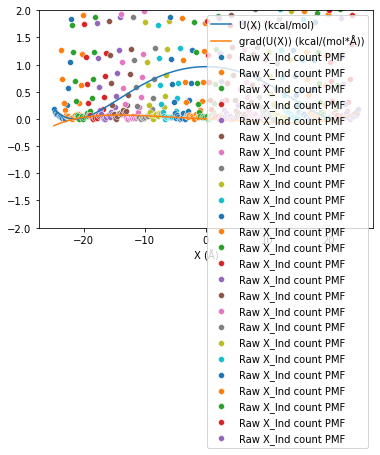

In [586]:
diffCoef=.0282*310.15/298.15 #Approximate scaling to body temperature 

symm_win_sim_data=[]
for iWin,winCenter in enumerate(symm_window_centers):
    win_potGradFun=symm_window_potGradFuns[iWin]
    bd_Sim=Simple_1D_BD_Sim(win_potGradFun)
    bd_Sim.set_parameters(dict(
        diffusionConstant=diffCoef,
        vmax=15.0,
        trajectorySnapshotRate=100,
        verbose=True,
        timestep=1.0
    ))
    bd_Sim.set_x0(winCenter)

    nsteps=1000000 #1 ns
    symm_win_sim_data.append(bd_Sim.run_sim(
        nsteps=nsteps,
        giveVelocities=True,
        pbar=tqdm.tqdm_notebook(total=nsteps)))

    trajData=symm_win_sim_data[iWin]
    binEdges=np.linspace(-25,25,251)
    binCenters=(binEdges[:-1]+binEdges[1:])/2.
    xgrid=binCenters
    sim_pmf_hist=np.histogram(
        a=trajData['trajectory'],
        bins=binEdges
    )
    #display(sim_pmf_hist)
    sim_pmf_vec=sim_pmf_hist[0]
    sim_pmf_vec=sim_pmf_vec/np.sum(sim_pmf_vec)
    sim_pmf_vec=-kbT*np.log(sim_pmf_vec)
    sim_pmf_mask=np.where(np.isfinite(sim_pmf_vec))
    sim_pmf_vec=sim_pmf_vec-np.min(
        sim_pmf_vec[sim_pmf_mask]
    )
    sns.scatterplot(
        x=xgrid[sim_pmf_mask],
        y=sim_pmf_vec[sim_pmf_mask],
        label='Raw X_Ind count PMF'
    )
    #plt.ylim(-.5,1.5)
    #plt.show()

xgrid=binCenters#np.linspace(-30,30,101)
sns.lineplot(
    x=xgrid,
    y=potFun(xgrid)-np.min(potFun(xgrid)),
    label='U(X) (kcal/mol)'
)
sns.lineplot(
    x=xgrid,
    y=potGradFun(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)
plt.ylim(-2,2)
plt.xlabel('X (Å)')
plt.show()

In [593]:
milestone_data_table=pd.DataFrame({
    'Window':(np.array([
        [iWin]*len(winData['trajectory']) \
        for iWin,winData in enumerate(symm_win_sim_data)
    ])).flatten(),
    'X':(np.array([
        winData['trajectory'] \
        for winData in symm_win_sim_data
    ])).flatten()
})
milestone_data_table['X_Ind']=milestone_data_table['X'].map(
    lambda x: np.argmin(np.abs(x-symm_window_centers))
)
display(milestone_data_table.head())
milestone_data_table.to_csv('symmetric_case.milestone_simulations_data.csv',index=False)

,Window,X,X_Ind
0,0,-24.000000,0
1,0,-24.424349,0
2,0,-25.012679,0
3,0,-24.137392,0
4,0,-23.157469,0


In [605]:
import json

In [614]:
symm_window_data=pd.DataFrame({
    'Window':np.arange(len(symm_window_centers)),
    'LHS_Edge':symm_window_lhs,
    'Center':symm_window_centers,
    'RHS_Edge':symm_window_rhs
})
print('saving window setup data')
display(symm_window_data.head())
symm_window_data.to_csv('symmetric_case.milestone_simulation_windows.csv',index=False)
import json
print('saving simulation parameter setup')
display(bd_Sim.parameter_dict)
with open('symmetric_case.milestone_simulation_parameters.json', 'w') as fp:
    json.dump(bd_Sim.parameter_dict, fp)

saving window setup data


,Window,LHS_Edge,Center,RHS_Edge
0,0,-25.0,-24.0,-23.0
1,1,-23.0,-22.0,-21.0
2,2,-21.0,-20.0,-19.0
3,3,-19.0,-18.0,-17.0
4,4,-17.0,-16.0,-15.0


saving simulation parameter setup


{'diffusionConstant': 0.02933499916149589,
 'temperature': 310.15,
 'vmax': 15.0,
 'trajectorySnapshotRate': 100,
 'periodicBoundaryLength': None,
 'timestep': 1.0,
 'verbose': True}

In [331]:
symmData=pd.read_csv("symmetric_case.raw_trajectory_data.csv")
symmData=symmData.drop(columns=symmData.columns[0])
symmData.head()

,Time,X,V
0,0,-25.000000,-0.042791
1,1,-16.265951,-0.112894
2,2,-25.195784,-0.037598
3,3,-24.306553,-0.131659
4,4,-17.931071,0.016879


## Simple Asymmetric Case

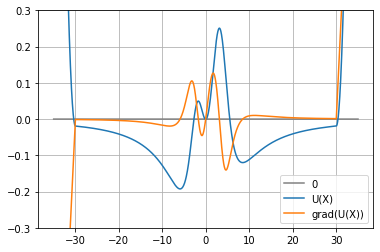

In [41]:
tempx=np.linspace(-35,35,1401)
def potFun2(x):
    return -.5*(((tempx-.67)/3.)**4-4)/(((tempx-.67)/3.)**4+4) + \
            .5*((tempx/3.)**2-2)/((tempx/3.)**2+2)+ \
            .125*(x>30.0)*(30.-x)**2 + \
            .125*(x<-30.0)*(-30.-x)**2

def potGradFun2(x):
    return ((36* x**9 - 192.96* x**8 - 843.509* x**7 + 1998.62* x**6 - 24565.5* x**5 + \
         31377.1* x**4 - 419813.* x**3 + 829957.* x**2 + 3.21835E6* x + 126292.)/ \
        ((x**2 + 18)**2 *(x**4 - 2.68* x**3 + 2.6934* x**2 - 1.20305* x + 324.202)**2)) - \
        .250*(x>30.0)*(30.-x) - .250*(x<-30.)*(-30.-x)

sns.lineplot(x=tempx,y=tempx*0.,label=0,color='grey')
sns.lineplot(x=tempx,y=potFun2(tempx),label="U(X)")
sns.lineplot(x=tempx,y=potGradFun2(tempx),label="grad(U(X))")
plt.ylim(-.3,.3)
plt.grid()
plt.show()

In [42]:
#Air(g)-water(g) diffusion constant: .282 cm**2/s (at 25 ºC)
# -> (10**-8)**2/10**-15 = 10**-1 Å**2/fs per cm**2/s
# so Air-water = .0282 Å**2/fs
diffCoef=.0282*310.15/398.15 #Approximate scaling to body temperature 

bd_Sim2=Simple_1D_BD_Sim(potGradFun2)
bd_Sim2.set_parameters(dict(
    diffusionConstant=diffCoef,
    vmax=100.0,
    trajectorySnapshotRate=1000,
    verbose=True,
    timestep=.5
))
bd_Sim2.set_x0(-25.)

In [43]:
display('x0=%f'%bd_Sim2.x0)
bd_Sim2.parameter_dict

'x0=-25.000000'

{'diffusionConstant': 0.021967173175938715,
 'temperature': 310.15,
 'vmax': 100.0,
 'trajectorySnapshotRate': 1000,
 'periodicBoundaryLength': None,
 'timestep': 0.5,
 'verbose': True}

In [44]:
nsteps=100000000
trajData2=bd_Sim2.run_sim(
    nsteps=nsteps,
    giveVelocities=True,
    pbar=tqdm.tqdm_notebook(total=nsteps))

/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


100000000


In [45]:
trajData2

{'trajectory': array([-25.        , -19.79050399, -21.67649869, ...,  -8.1462459 ,
         -5.15086014,  -5.84577286]),
 'velocities': array([-0.01303789, -0.02496478, -0.09762899, ..., -0.04993462,
         0.05124451,  0.        ])}

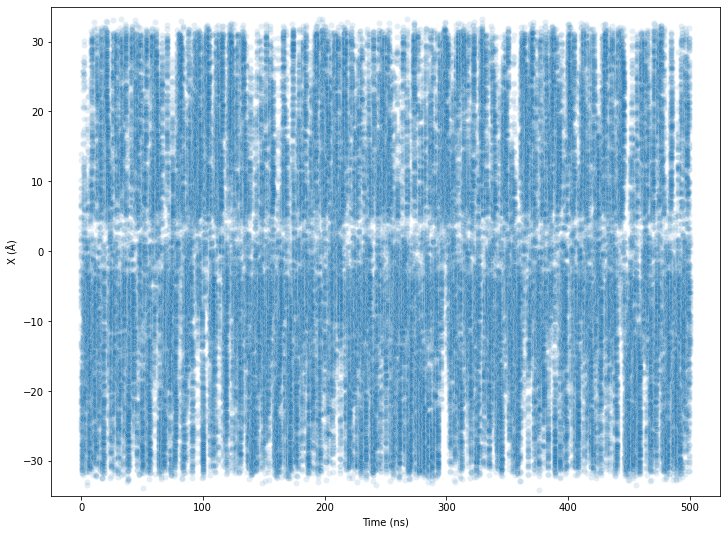

In [135]:
fig,axs=plt.subplots(1,1)
fig.set_figwidth(12)
fig.set_figheight(9)
sns.scatterplot(
    x=np.arange(len(trajData2['trajectory']))*.005,
    y=trajData2['trajectory'],
    alpha=.125,
    ax=axs
)
plt.ylabel('X (Å)')
plt.xlabel('Time (ns)')
plt.ylim(-35,35)
plt.show()

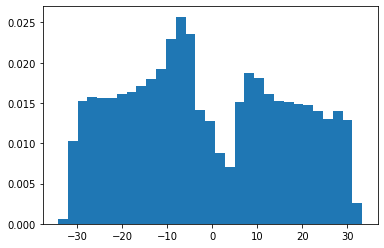

In [47]:
plt.hist(
    x=trajData2['trajectory'],
    bins=31,
    density=True,
    #log=True
)
plt.show()

In [48]:
np.histogram(trajData2['trajectory'],bins=np.linspace(-30,30,31))

(array([3034, 3111, 3139, 3146, 3178, 3249, 3317, 3469, 3648, 3903, 4697,
        5140, 4790, 3101, 2474, 2235, 1220, 2155, 3477, 3787, 3484, 3229,
        3046, 3015, 2985, 2930, 2856, 2654, 2753, 2774]),
 array([-30., -28., -26., -24., -22., -20., -18., -16., -14., -12., -10.,
         -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.,  12.,
         14.,  16.,  18.,  20.,  22.,  24.,  26.,  28.,  30.]))

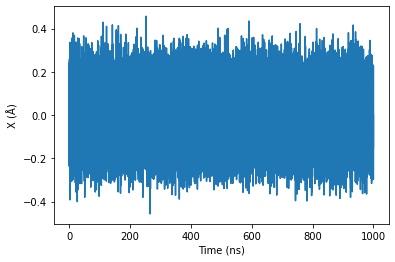

In [136]:
sns.lineplot(
    x=np.arange(len(trajData2['velocities']))*.01,
    y=trajData2['velocities']
)
plt.ylabel('X (Å)')
plt.xlabel('Time (ns)')
#plt.ylim(-10,10)
plt.show()

In [141]:
trajData2['trajectory'].shape

(100000,)

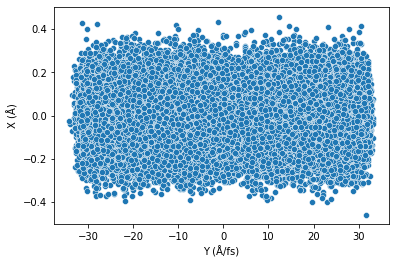

In [143]:
sns.scatterplot(
    x=trajData2['trajectory'],
    y=trajData2['velocities'][1:]
)
plt.ylabel('X (Å)')
plt.xlabel('Y (Å/fs)')
#plt.ylim(-10,10)
plt.show()

In [55]:
trajTable2=pd.DataFrame(dict(
    Time=np.arange(len(trajData2['trajectory'])),
    X=trajData2['trajectory']
))
if 'velocities' in trajData2:
    trajTable2['V']=np.array(trajData2['velocities'])[:len(trajTable2)]
    
display(trajTable2.head())
trajTable2.to_csv('asymmetric_case.raw_trajectory_data.csv')

,Time,X,V
0,0,-25.000000,-0.013038
1,1,-19.790504,-0.024965
2,2,-21.676499,-0.097629
3,3,-21.740214,-0.137927
4,4,-18.093114,0.047236


# Load and Analyze Trajectory Data

## Symmetric Case

In [5]:
import analysis_functions

### Subsampling Brute Force Simulation

In [652]:
symmData=pd.read_csv("symmetric_case.raw_trajectory_data.csv")
symmData=symmData.drop(columns=symmData.columns[0])
display(symmData.head())
display(symmData.describe())

with open('symmetric_case.raw_trajectory_simulation_parameters.json','r') as infile:
    symm_sim_parameters=json.load(infile)
symm_sim_parameters

,Time,X,V
0,0,-20.000000,-0.115835
1,1,-18.448328,0.058234
2,2,-21.740043,0.111448
3,3,-25.962215,-0.005899
4,4,-21.264881,-0.279032


,Time,X,V
count,100000.000000,100000.000000,100000.000000
mean,49999.500000,-0.688521,0.000252
std,28867.657797,18.812724,0.242665
min,0.000000,-32.889040,-0.992580
25%,24999.750000,-19.191276,-0.161826
50%,49999.500000,-2.668575,-0.000098
75%,74999.250000,18.483397,0.165066
max,99999.000000,33.480426,0.970008


{'diffusionConstant': 0.02933499916149589,
 'temperature': 310.15,
 'vmax': 15.0,
 'trajectorySnapshotRate': 1000,
 'periodicBoundaryLength': None,
 'timestep': 1.0,
 'verbose': True}

In [640]:
window_setup_data=pd.read_csv('symmetric_case.milestone_simulation_windows.csv')
window_setup_data.LHS_Edge.iloc[:1].to_numpy()

array([-25.])

In [641]:
#lets use the window setup from milestoning for a good comparison later
window_setup_data=pd.read_csv('symmetric_case.milestone_simulation_windows.csv')
display(window_setup_data.head())
binEdges=np.concatenate([
    window_setup_data.LHS_Edge.iloc[:1].to_numpy(),
    window_setup_data.RHS_Edge.to_numpy()
])#np.linspace(-25,25,26)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
print(
    "binEdges = %s"%binEdges + "\nbinCenters = %s"%binCenters
)
symmData['X_Ind']=symmData['X'].apply(
    lambda x: np.argmin(np.abs(x-binCenters))
)
symmData.head()

,Window,LHS_Edge,Center,RHS_Edge
0,0,-25.0,-24.0,-23.0
1,1,-23.0,-22.0,-21.0
2,2,-21.0,-20.0,-19.0
3,3,-19.0,-18.0,-17.0
4,4,-17.0,-16.0,-15.0


binEdges = [-25. -23. -21. -19. -17. -15. -13. -11.  -9.  -7.  -5.  -3.  -1.   1.
   3.   5.   7.   9.  11.  13.  15.  17.  19.  21.  23.  25.]
binCenters = [-24. -22. -20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.
   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.]


,Time,X,V,X_Ind
0,0,-20.000000,-0.115835,2
1,1,-18.448328,0.058234,3
2,2,-21.740043,0.111448,1
3,3,-25.962215,-0.005899,0
4,4,-21.264881,-0.279032,1


In [642]:
binnedDataFrames=[]
for binID in tqdm.tqdm_notebook(np.arange(binCenters.shape[0])):
    tempFrame=symmData.query(
            'abs(X_Ind - {binCenter:g}) <= 1'.format(binCenter=binID)
    ).copy()
    tempFrame['Window']=binID
    tempFrame['Frame']=np.arange(len(tempFrame))
    binnedDataFrames.append(tempFrame.copy())
symmData_binned=pd.concat(binnedDataFrames)
symmData_binned.head()

/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


,Time,X,V,X_Ind,Window,Frame
2,2,-21.740043,0.111448,1,0,0
3,3,-25.962215,-0.005899,0,0,1
4,4,-21.264881,-0.279032,1,0,2
5,5,-31.190160,0.251906,0,0,3
6,6,-21.590432,-0.017043,1,0,4


In [653]:
histDat.index.to_numpy()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

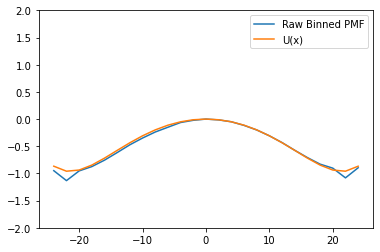

In [664]:
histDat=symmData_binned.groupby('Window').size()
symm_raw_pmf=-kb*symm_sim_parameters['temperature']*np.log(histDat)
symm_raw_pmf=symm_raw_pmf-np.max(symm_raw_pmf)
xgrid=np.array(binCenters[histDat.index.to_numpy()],dtype=float)
sns.lineplot(
    x=xgrid,
    y=symm_raw_pmf,
    label='Raw Binned PMF'
)
sns.lineplot(
    x=xgrid,
    y=potFun(xgrid)-np.max(potFun(xgrid)),
    label='U(x)'
)
plt.ylim(-2,2)
plt.show()

In [599]:
symm_milestoning_data=analysis_functions.add_indexed_milestoning_analysis_columns(
    milestoneData=symmData_binned,
    windowColumn='Window',xIndexColumn='X_Ind',frameCol='Time',
    repColumn=None,groupingColumn=None,verbose=False,
    verboseLevel=0)
symm_milestoning_data.head()

/data/wesley/Milestone_Error_Analysis_Testing/analysis_functions.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simData[groupingCol]=0
/data/wesley/Milestone_Error_Analysis_Testing/analysis_functions.py:431: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simData[repCol]=0
/data/wesley/Milestone_Error_Analysis_Testing/analysis_functions.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,Window,X_Ind,Group,Rep,Time,Escape_Vector,Reentry_Vector
1,0,0,0,0,1,0,-1
2,0,0,0,0,2,0,-1
3,0,1,0,0,3,1,-1
4,0,1,0,0,4,-1,-1
5,0,0,0,0,5,0,1


In [600]:
symm_milestone_results=analysis_functions.compute_analysis_group_Qdata(
    groupDataFrame=symm_milestoning_data,
    windowColumn='Window',binSet=symm_milestoning_data.Window.unique(),
    sourceWindows=None,sinkWindows=None,
    repColumn='Rep',givePiVec=True,
    giveBins=True,giveBinMap=True,
    giveEscapeMat=True,giveCounts=True,
    giveCountsMat=True,giveEdgeMap=True,
    giveQtargets=True)

Computing R and N: ( 0 : 0 ) ( 1 : 0 ) ( 2 : 0 ) ( 3 : 0 ) ( 4 : 0 ) ( 5 : 0 ) ( 6 : 0 ) ( 7 : 0 ) ( 8 : 0 ) ( 9 : 0 ) ( 10 : 0 ) ( 11 : 0 ) ( 12 : 0 ) ( 13 : 0 ) ( 14 : 0 ) ( 15 : 0 ) ( 16 : 0 ) ( 17 : 0 ) ( 18 : 0 ) ( 19 : 0 ) ( 20 : 0 ) ( 21 : 0 ) ( 22 : 0 ) ( 23 : 0 ) ( 24 : 0 ) 


In [601]:
kbT

0.6159191312499999

/cm/local/apps/python37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


ValueError: arrays must all be same length

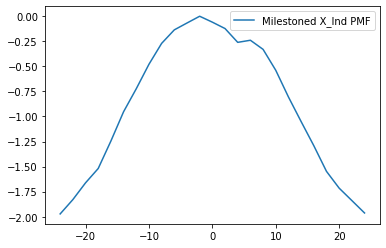

In [602]:
kb=0.001985875
Tsim=310.15
kbT=kb*Tsim
pmf_vec=-kbT*np.log(symm_milestone_results['piVec']/symm_milestone_results['piVec'].min())
sns.lineplot(
    #np.arange(pmf_vec.shape[0]),
    binCenters,
    pmf_vec,
    label='Milestoned X_Ind PMF'
)
sim_pmf_vec=symmData[['X_Ind','Time']].groupby('X_Ind').count()['Time'].to_numpy()
sim_pmf_vec=sim_pmf_vec/np.sum(sim_pmf_vec)
sim_pmf_vec=-kbT*np.log(sim_pmf_vec/np.min(sim_pmf_vec))
sns.lineplot(
    x=xgrid,
    y=sim_pmf_vec,
    label='Raw X_Ind count PMF'
)
plt.show()

xgrid=binCenters#np.linspace(-30,30,101)
sns.lineplot(
    x=xgrid,
    y=potFun(xgrid),
    label='U(X) (kcal/mol)'
)
sns.lineplot(
    x=xgrid,
    y=potGradFun(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)
plt.ylim(-.5,.5)
plt.xlabel('X (Å)')
plt.show()



In [100]:
sim_pi_vec=symmData[['X_Ind','Time']].groupby('X_Ind').count()['Time'].to_numpy()
sim_pi_vec=sim_pi_vec/np.sum(sim_pi_vec)
sim_pi_vec=-kbT*np.log(sim_pi_vec)
sim_pi_vec

array([1.56667535, 1.34961594, 1.42278096, 1.78262968, 2.2987362 ,
       2.85517283, 3.50450568, 3.81852584, 4.50128043, 4.73289757,
       5.18719887, 4.99616851, 5.24590223, 4.90122416, 4.90122416,
       4.48316385, 4.17391582, 3.64514128, 3.12589665, 2.52203156,
       1.98751437, 1.48405861, 1.14388156, 1.06143485, 1.29628575])

## Milestone Simulations

In [615]:
symm_milestone_data=pd.read_csv('symmetric_case.milestone_simulations_data.csv')
symm_milestone_window_data=pd.read_csv('symmetric_case.milestone_simulation_windows.csv')
with open('symmetric_case.milestone_simulation_parameters.json','r') as paramFile:
    symm_milestone_simulation_parameters=json.load(paramFile)

display(symm_milestone_data.head())
display(symm_milestone_window_data.head())
display(symm_milestone_simulation_parameters)

,Window,X,X_Ind
0,0,-24.000000,0
1,0,-24.424349,0
2,0,-25.012679,0
3,0,-24.137392,0
4,0,-23.157469,0


,Window,LHS_Edge,Center,RHS_Edge
0,0,-25.0,-24.0,-23.0
1,1,-23.0,-22.0,-21.0
2,2,-21.0,-20.0,-19.0
3,3,-19.0,-18.0,-17.0
4,4,-17.0,-16.0,-15.0


{'diffusionConstant': 0.02933499916149589,
 'temperature': 310.15,
 'vmax': 15.0,
 'trajectorySnapshotRate': 100,
 'periodicBoundaryLength': None,
 'timestep': 1.0,
 'verbose': True}

In [616]:
symm_milestoning_data=analysis_functions.add_indexed_milestoning_analysis_columns(
    milestoneData=symm_milestone_data,
    windowColumn='Window',xIndexColumn='X_Ind',frameCol='Time',
    repColumn=None,groupingColumn=None,verbose=False,
    verboseLevel=0)
symm_milestoning_data.head()

,Window,X_Ind,Group,Rep,Time,Escape_Vector,Reentry_Vector
0,0,0,0,0,0,0,-1
1,0,0,0,0,1,0,-1
2,0,0,0,0,2,0,-1
3,0,0,0,0,3,0,-1
4,0,0,0,0,4,0,-1


In [617]:
symm_milestone_results=analysis_functions.compute_analysis_group_Qdata(
    groupDataFrame=symm_milestoning_data,
    windowColumn='Window',binSet=symm_milestoning_data.Window.unique(),
    sourceWindows=None,sinkWindows=None,
    repColumn='Rep',givePiVec=True,
    giveBins=True,giveBinMap=True,
    giveEscapeMat=True,giveCounts=True,
    giveCountsMat=True,giveEdgeMap=True,
    giveQtargets=True)

Computing R and N: ( 0 : 0 ) ( 1 : 0 ) ( 2 : 0 ) ( 3 : 0 ) ( 4 : 0 ) ( 5 : 0 ) ( 6 : 0 ) ( 7 : 0 ) ( 8 : 0 ) ( 9 : 0 ) ( 10 : 0 ) ( 11 : 0 ) ( 12 : 0 ) ( 13 : 0 ) ( 14 : 0 ) ( 15 : 0 ) ( 16 : 0 ) ( 17 : 0 ) ( 18 : 0 ) ( 19 : 0 ) ( 20 : 0 ) ( 21 : 0 ) ( 22 : 0 ) ( 23 : 0 ) ( 24 : 0 ) 


/cm/local/apps/python37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


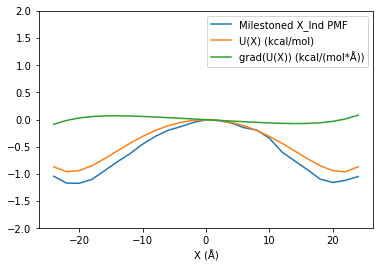

In [622]:
def potFun(x):
    return(5.0*(1.0/1024.0*(10**-6)*(x)**6-.0625*(10**-2)*(x)**2))
def potGradFun(x):
    return(5.0*(6.0*1.0/1024.0*(10**-6)*(x)**5-2.0*.0625*(10**-2)*(x)))

kb=0.001985875
Tsim=symm_milestone_simulation_parameters['temperature']
kbT=kb*Tsim
pmf_vec=-kbT*np.log(symm_milestone_results['piVec']/symm_milestone_results['piVec'].min())
binCenters=symm_milestone_window_data['Center'].to_numpy()
sns.lineplot(
    #np.arange(pmf_vec.shape[0]),
    binCenters,
    pmf_vec,
    label='Milestoned X_Ind PMF'
)

xgrid=symm_milestone_window_data['Center'].to_numpy() #np.linspace(-30,30,101)
sns.lineplot(
    x=xgrid,
    y=potFun(xgrid),
    label='U(X) (kcal/mol)'
)
sns.lineplot(
    x=xgrid,
    y=potGradFun(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)
plt.ylim(-2,2)
plt.xlabel('X (Å)')
plt.show()

In [618]:
symm_milestone_simulation_parameters

{'diffusionConstant': 0.02933499916149589,
 'temperature': 310.15,
 'vmax': 15.0,
 'trajectorySnapshotRate': 100,
 'periodicBoundaryLength': None,
 'timestep': 1.0,
 'verbose': True}

(100000,)

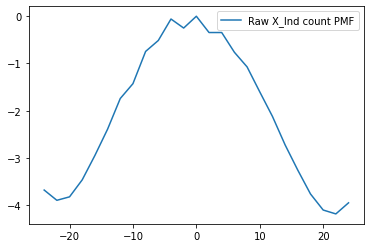

In [108]:
display(symmData.Time.unique().shape)
sim_pmf_vec=symmData[['X_Ind','Time']].groupby('X_Ind').count()['Time'].to_numpy()
sim_pmf_vec=sim_pmf_vec/np.sum(sim_pmf_vec)
sim_pmf_vec=-kbT*np.log(sim_pmf_vec/np.min(sim_pmf_vec))
sns.lineplot(
    x=xgrid,
    y=sim_pmf_vec,
    label='Raw X_Ind count PMF'
)
plt.show()

In [109]:
nTimeBlocks=10
timeBlockSize=symmData.Time.max()/nTimeBlocks
symmData['TimeBlock']=pd.Series(symmData['Time']/timeBlockSize,dtype=int)
symmData.head()

,Time,X,X_Ind,TimeBlock
0,0,-25.000000,0,0
1,1,-24.570596,0,0
2,2,-22.340591,1,0
3,3,-20.262445,2,0
4,4,-20.412326,2,0


/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


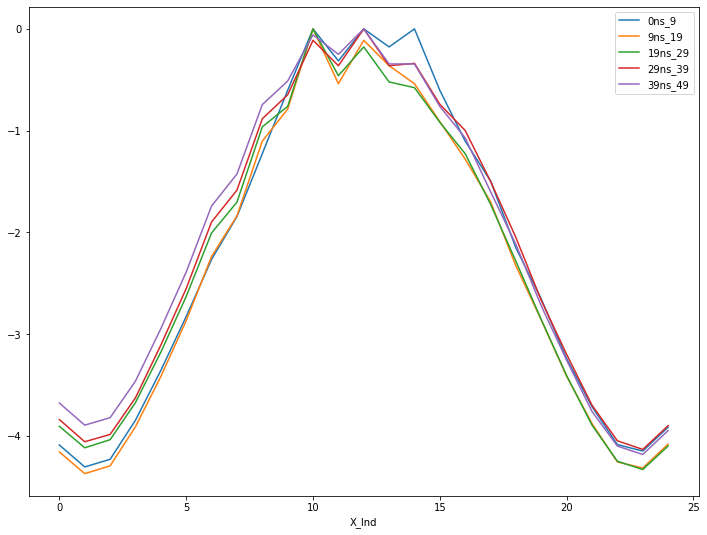

In [124]:
nTimeBlocks=5
timeBlockSize=symmData.Time.max()/nTimeBlocks
symmData['TimeBlock']=pd.Series(symmData['Time']/timeBlockSize,dtype=int)
symmData.head()
dt=bd_Sim.parameter_dict['timestep']*bd_Sim.parameter_dict['trajectorySnapshotRate']/1E6
timeBlock_dt=dt*timeBlockSize
fig,axs=plt.subplots(1,1)
fig.set_figheight(9)
fig.set_figwidth(12)
for iTimeBlock in tqdm.tqdm_notebook(np.arange(nTimeBlocks)):
    timeBlockGroupName=iTimeBlock
    timeBlockGroupData=symmData.query('TimeBlock <= {blockID}'.format(blockID=iTimeBlock))
    plotLabel='{tStart:g}ns_{tEnd:g}'.format(
        tStart=int(timeBlockGroupName*timeBlock_dt),
        tEnd=int((timeBlockGroupName+1)*timeBlock_dt))
    timeBlock_pmf_vec=timeBlockGroupData[['X_Ind','Time']].groupby('X_Ind').count()['Time'].to_numpy()
    timeBlock_xgrid=timeBlockGroupData[['X_Ind','Time']].groupby('X_Ind').count()['Time'].index
    timeBlock_pmf_vec=timeBlock_pmf_vec/np.sum(timeBlock_pmf_vec)
    timeBlock_pmf_vec=-kbT*np.log(timeBlock_pmf_vec/np.min(timeBlock_pmf_vec))
    sns.lineplot(
        x=timeBlock_xgrid,
        y=timeBlock_pmf_vec,
        label=plotLabel,
        ax=axs
    )
plt.show()

In [113]:
xgrid.shape

(25,)

In [114]:
timeBlock_pmf_vec.shape

(24,)

In [530]:
np.array([[1,226]+226*ii for ii in np.arange(6)])

array([[   1,  226],
       [ 227,  452],
       [ 453,  678],
       [ 679,  904],
       [ 905, 1130],
       [1131, 1356]])

In [531]:
3734-3

3731

In [536]:
1550*2-433-385-140-600-800-160-300-65

218